### Sensitivity Analysis

In [1]:
import numpy as np
import sys
import os
import pandas as pd
import random
from SALib.analyze import morris as morris_analyze


# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from src.analysis.sensitivity import generate_morris_samples, rescale_samples, apply_dependent_parameters, run_morris_analysis, plot_morris_grid, summarize_morris_results

#### Morris Analysis
In the following the Morris samples are generated. All samples are in the bounds [0,1]. The samples are then rescaled to their original bounds. The dependent parameters are sampled by first calculating the bounds and then mapping the samples to these bounds.

In [2]:
dependent_parameter_names=['Pc_des']
samples_df, trajectories, problem = generate_morris_samples(PARAMETER_RANGES, dependent_parameter_names)

df = rescale_samples(samples_df, PARAMETER_RANGES)

dependent_parameters = [{'parameter_name': 'Pc_des',
                         'function': lambda Pa_des: (np.maximum(1.1e5, Pa_des - 0.5e5), np.maximum(1.1e5, Pa_des - 0.1e5)),
                         'dependent_param': 'Pa_des'}]
df = apply_dependent_parameters(df, dependent_parameters)



In [3]:
saved_data_file = True
save_filepath = "../data/raw/N10_levels4_seed42.pkl"
if saved_data_file:
    data = pd.read_pickle(save_filepath)
else:
    df = get_polarisation_curve_samples(sampled_parameters=df.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=save_filepath, save_every=10)


Run the Morris analysis and and plot the results

In [4]:
morris_all = run_morris_analysis(samples_df, problem, output=data['Ucell'])


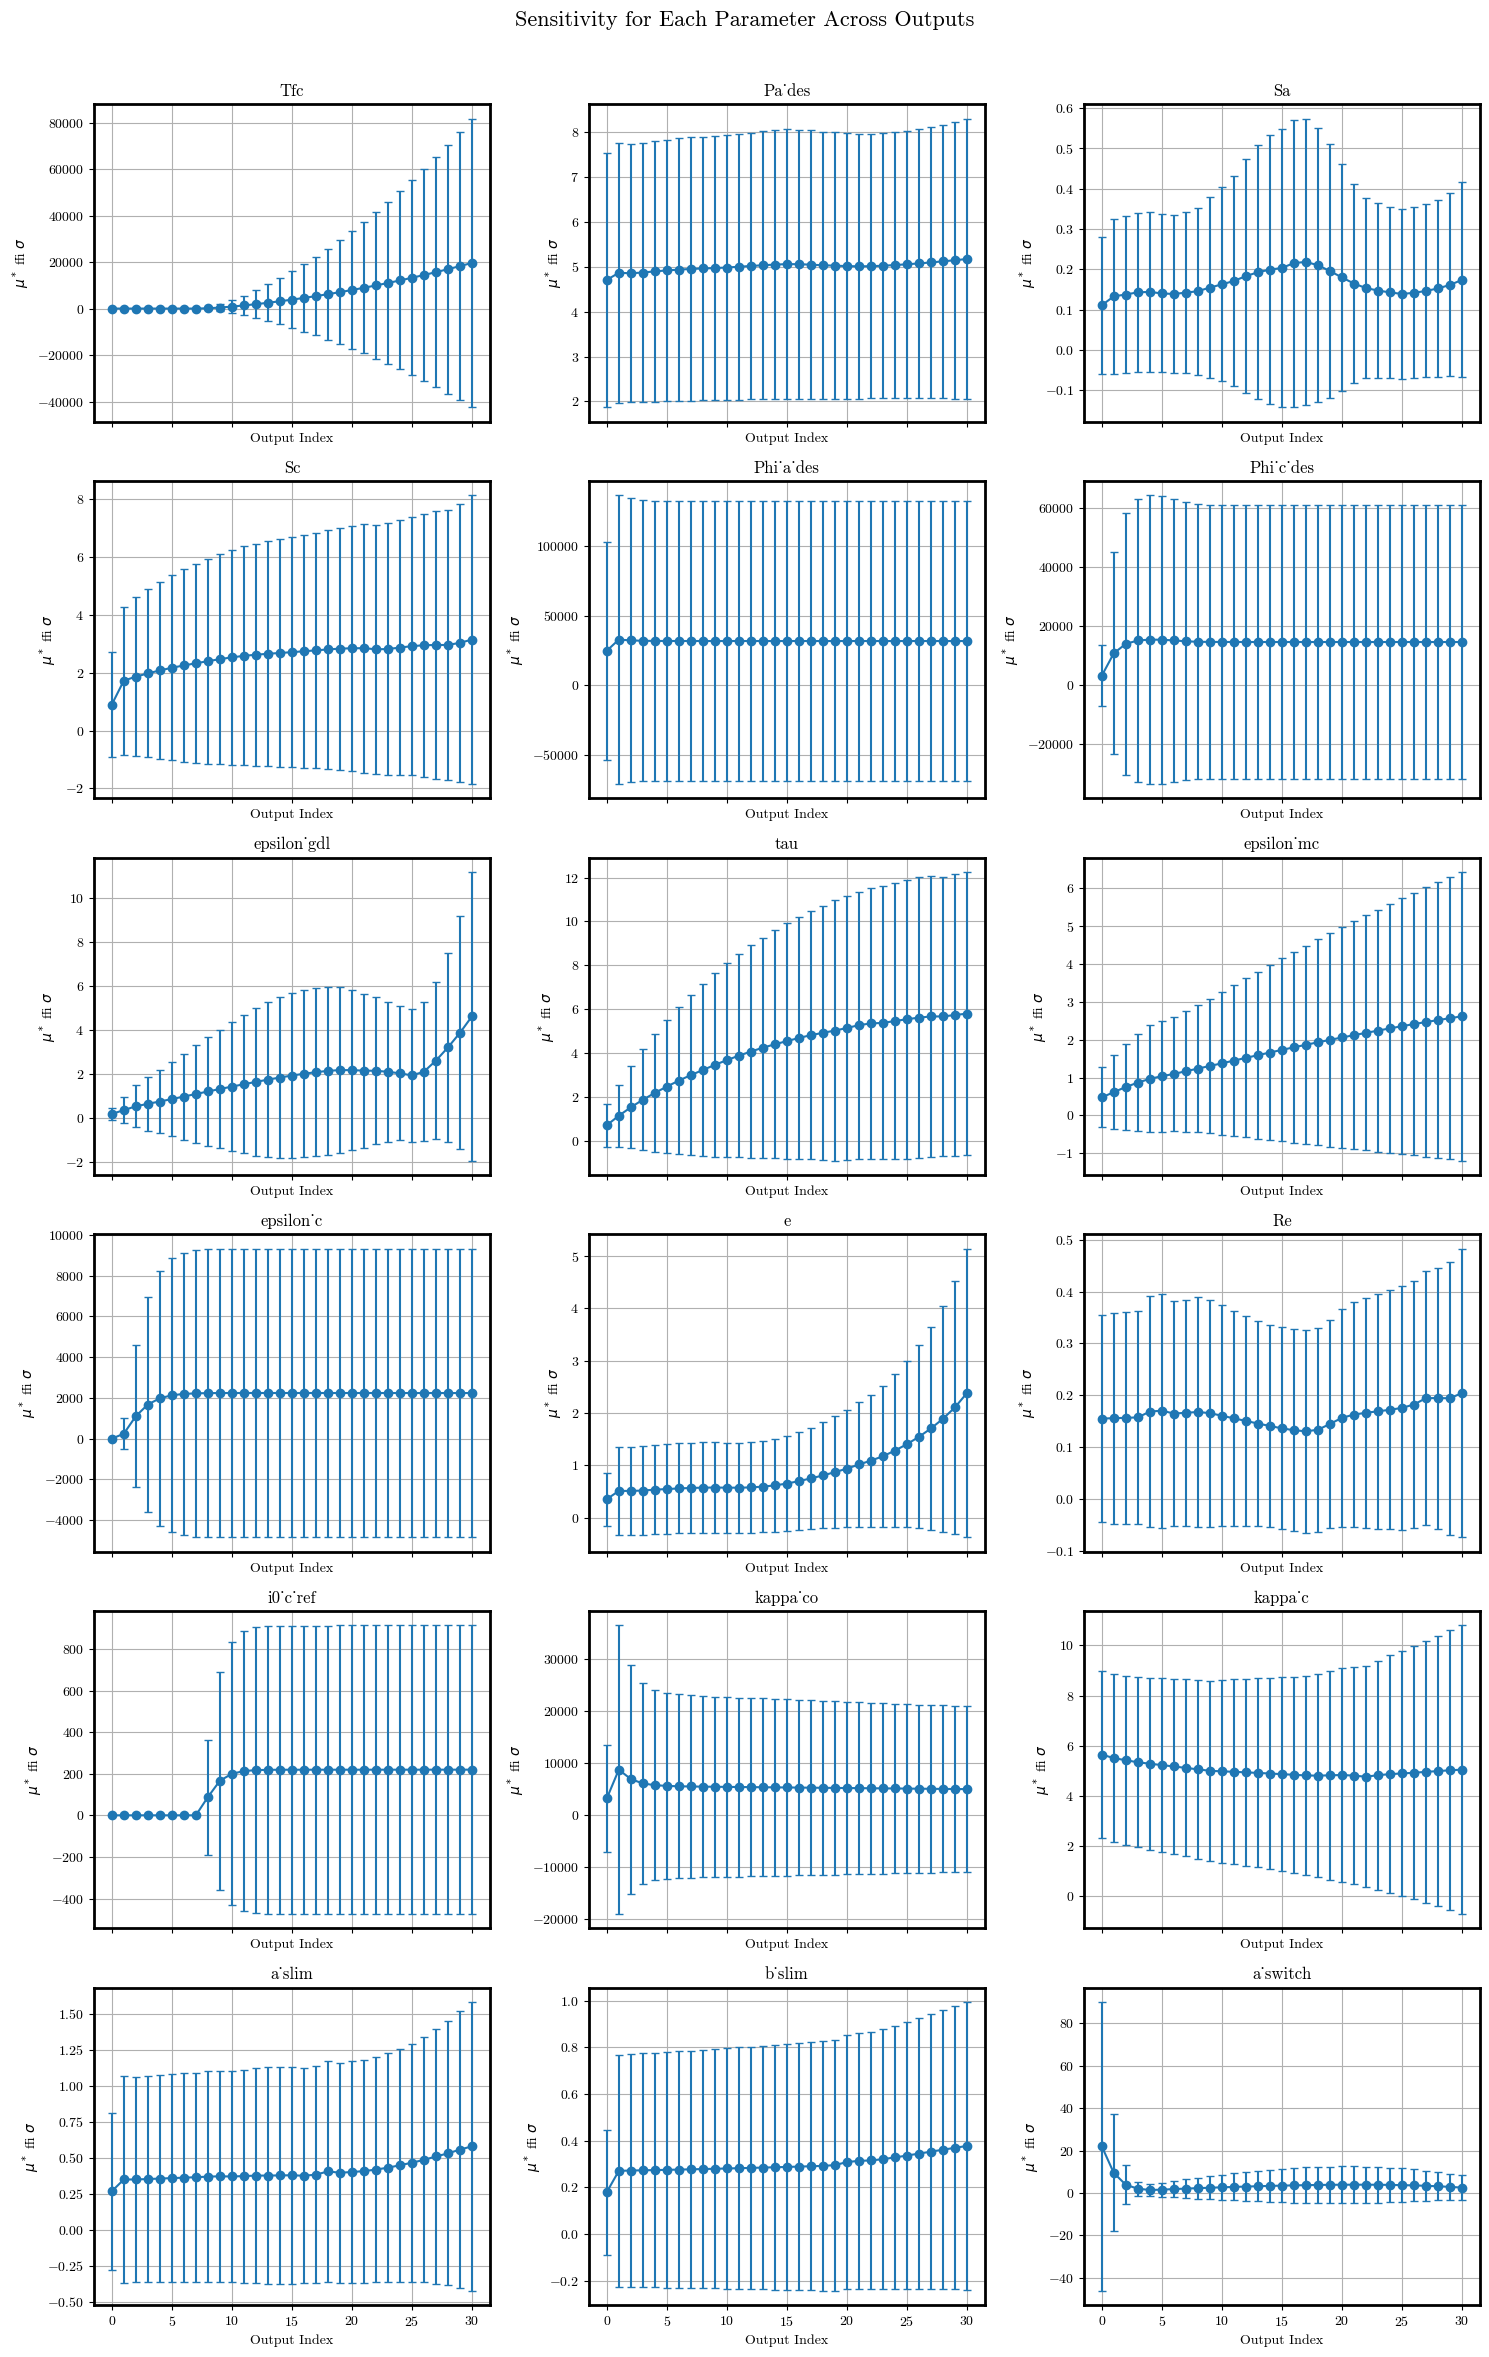

In [5]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=False)

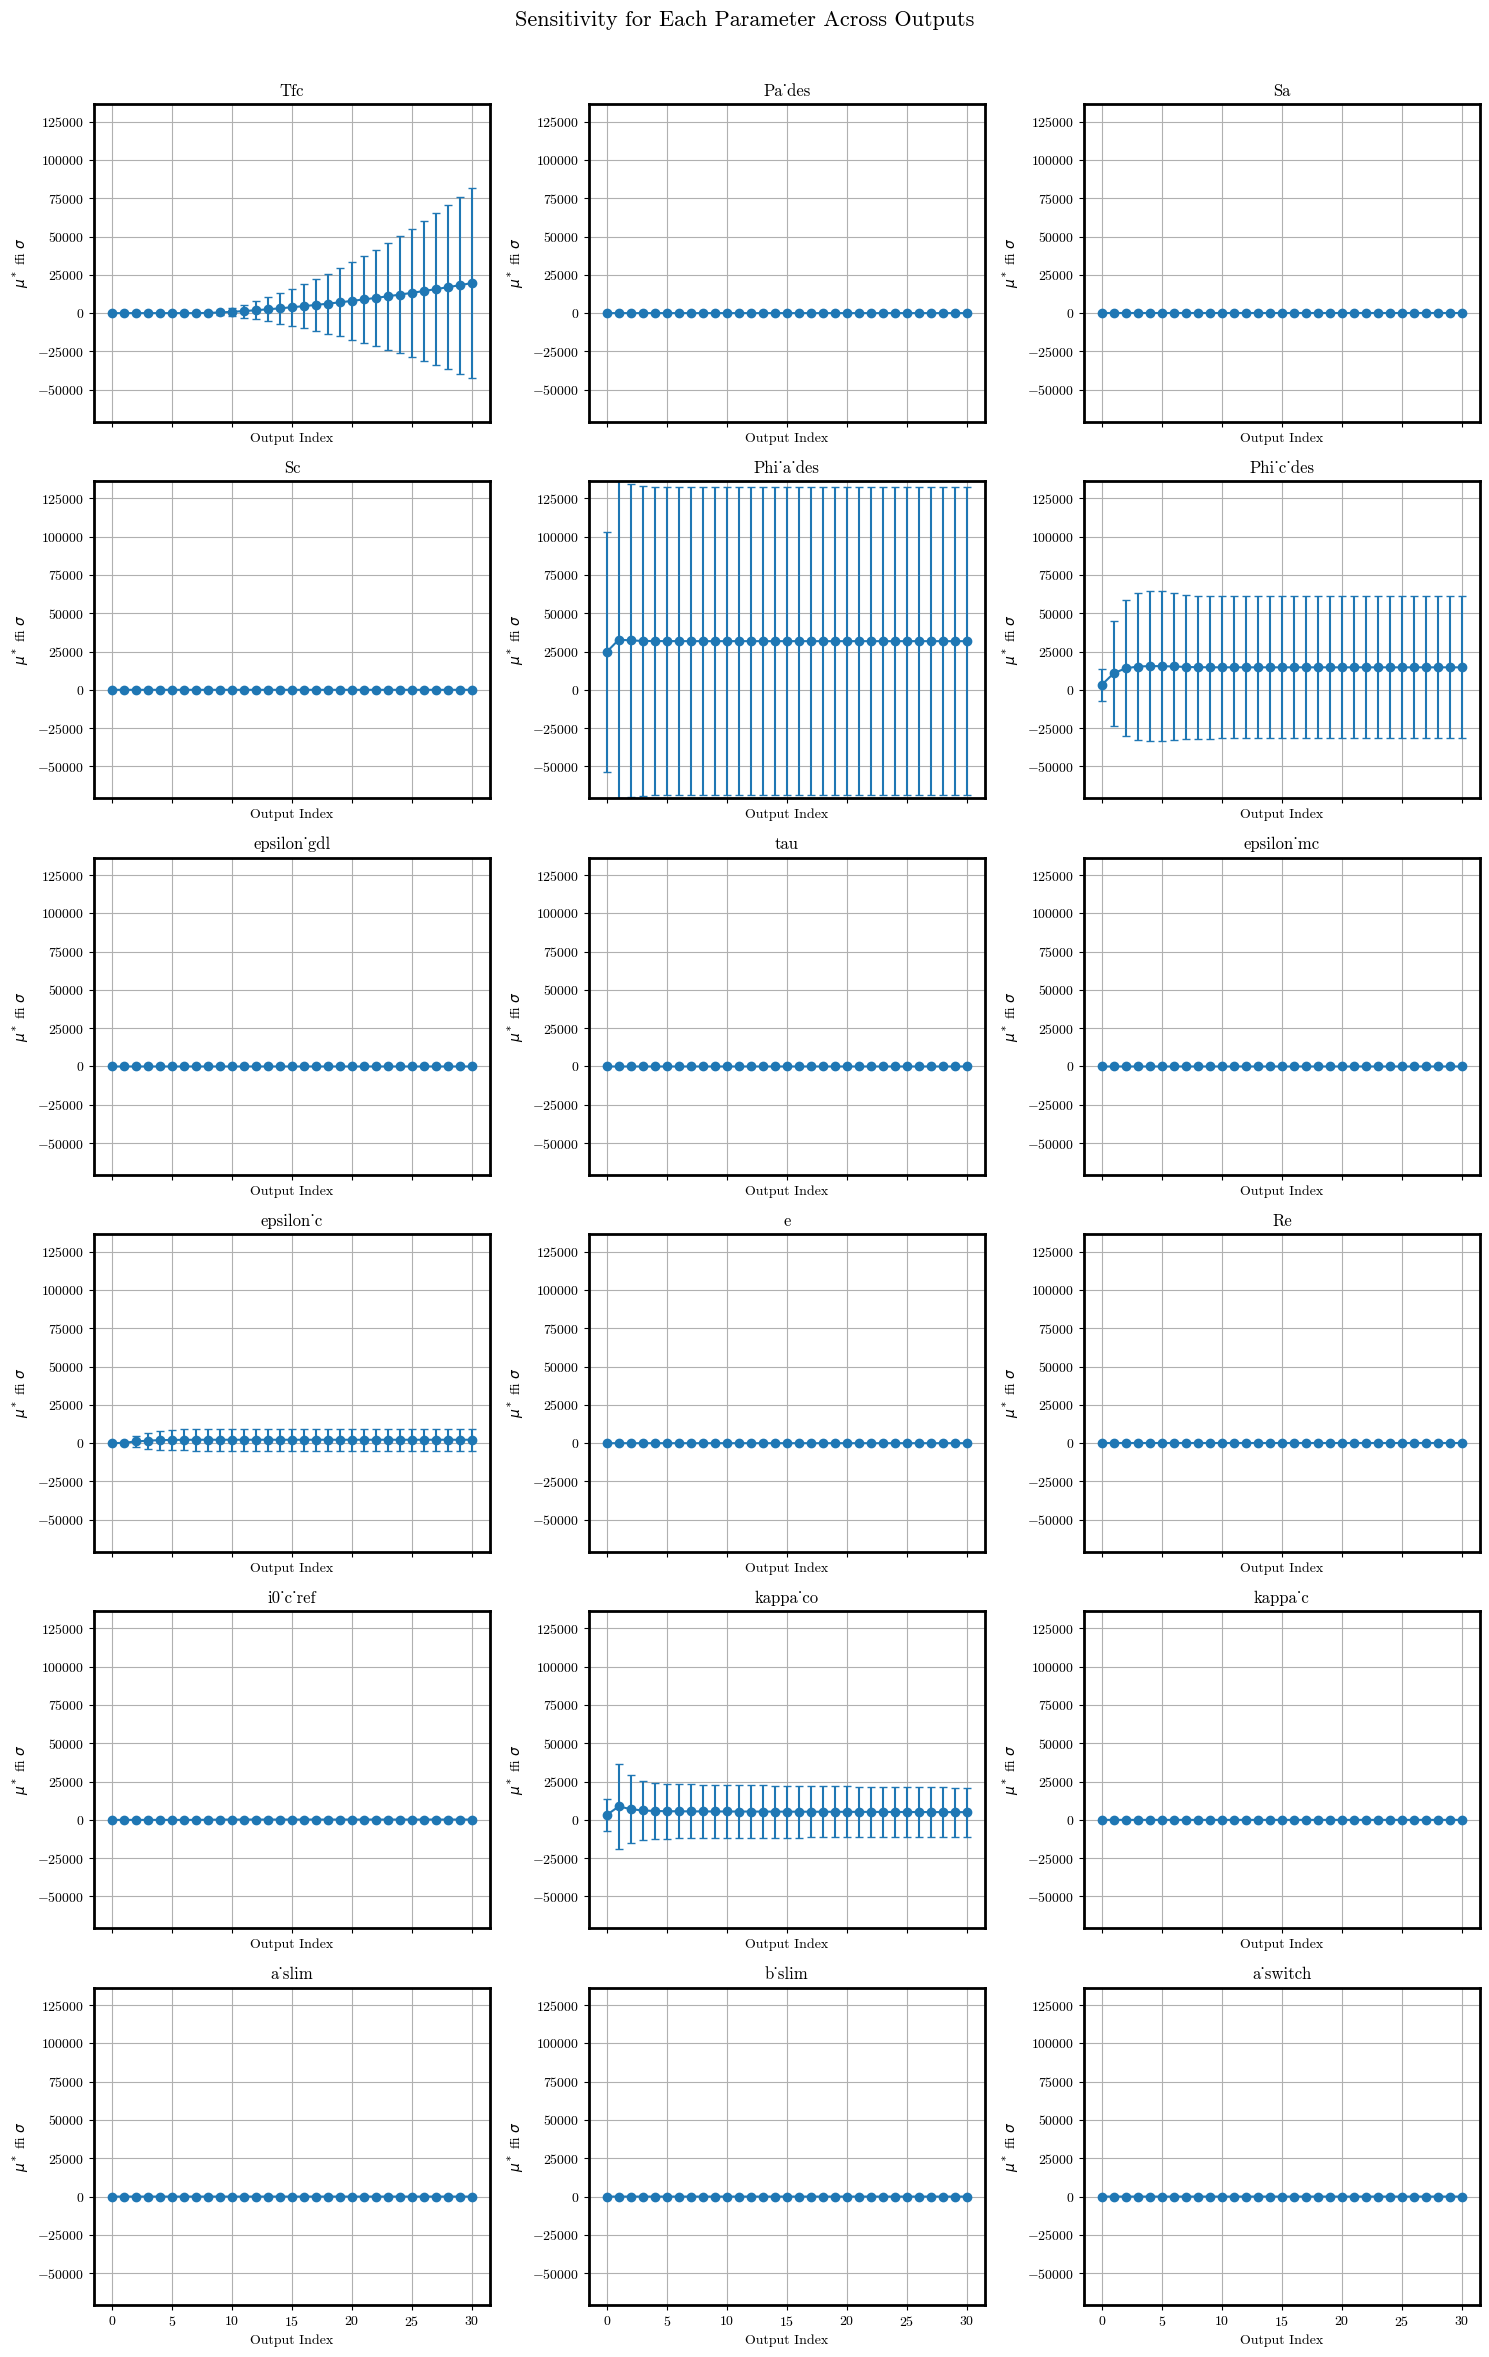

In [6]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=True)


In [8]:
summarize_morris_results(morris_all, problem).head()

,Parameter,Mu*_mean,Mu*_std
0,Phi_a_des,31595.542477,1258.179368
1,Phi_c_des,14265.064501,2142.365122
2,Tfc,5979.956115,6249.471233
3,kappa_co,5453.908350,806.411341
4,epsilon_c,2032.426903,550.203692


### Morris analysis with scalar output

The output function is first aggregated using AUC and the sum of the voltages over the current density. The current density is divided into three regions. The aggregation of the function using the sum of the voltages is once performed on the whole range and once on each of the regions separately.

In [10]:
data['AUC'] = data.apply(lambda row: np.trapezoid(row['Ucell'], row['ifc']), axis=1)

# Calculate simple sum of Ucell values
data['Ucell_sum'] = data['Ucell'].apply(np.sum)

def calculate_Ucell_sum(row):
    # Get the ifc value and Ucell list
    ifc = row['ifc']
    Ucell = row['Ucell']
    
    # Initialize sums for each region
    region_1_sum = 0
    region_2_sum = 0
    region_3_sum = 0
    
    for i in range(len(ifc)):
        if ifc[i] < 0.4:
            region_1_sum += Ucell[i]
        elif 0.4 <= ifc[i] < 1.6:
            region_2_sum += Ucell[i]
        elif ifc[i] >= 1.6:
            region_3_sum += Ucell[i]
    
    return pd.Series({
        'Ucell_sum_region_1': region_1_sum,
        'Ucell_sum_region_2': region_2_sum,
        'Ucell_sum_region_3': region_3_sum
    })

# Apply the function to each row and assign the results to new columns
data[['Ucell_sum_region_1', 'Ucell_sum_region_2', 'Ucell_sum_region_3']] = data.apply(calculate_Ucell_sum, axis=1)
data.head()


,Tfc,Pa_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Hgc,Wgc,Lgc,ifc,Ucell,AUC,Ucell_sum,Ucell_sum_region_1,Ucell_sum_region_2,Ucell_sum_region_3
0,353.0,110000.000000,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008215564261179306, 0.10082019791770877, 0...","[5.423745073547675, 3.9048212274475746, 3.6352...",3.724598,39.255576,16.360973,25.663905,-2.769302
1,333.0,110000.000000,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008235235619106884, 0.10082216832538225, 0...","[6.177963358336651, 4.724602606265465, 4.46943...",7.360155,76.405254,19.630821,38.969050,17.805382
2,333.0,236666.666667,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008225624678172284, 0.10082120563468357, 0...","[10.665891631119756, 9.06289245874684, 8.84515...",20.267450,209.892599,37.267367,92.906978,79.718254
3,333.0,236666.666667,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.2,...,0.0005,0.00045,9.67,"[0.0008075417455922885, 0.10080615946564639, 0...","[10.103588870316795, 8.352702590254658, 8.1338...",18.945837,196.419078,34.567222,85.753230,76.098625
4,333.0,236666.666667,1.1,4.133333,1.0,0.366667,0.633333,2.0,0.15,0.2,...,0.0005,0.00045,9.67,"[0.0008265779356133262, 0.10082522774847498, 0...","[9.77406440072347, 8.056043845170988, 7.852580...",18.058059,187.211153,33.383752,82.336265,71.491137


In [ ]:
morris_all = morris_analyze.analyze(
            problem=problem,
            X=samples_df.to_numpy(),
            Y=data['AUC'].to_numpy(),
            conf_level=0.95,
            num_levels=4,
            print_to_console=False
        )

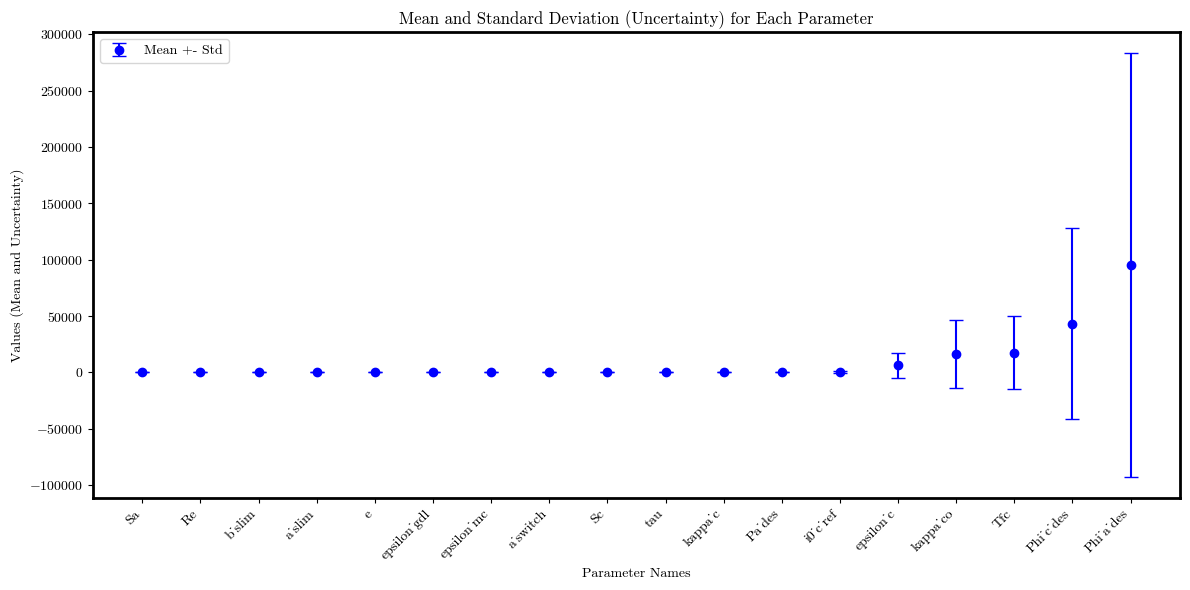

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_results(morris_all):
    """
    Plots the Morris sensitivity analysis results.
    
    Parameters:
        morris_all (dict): Dictionary containing the sensitivity analysis results with keys
                            'names', 'mu_star', and 'mu_star_conf'.
    """
    # Data from the morris_all dictionary
    names = morris_all['names']
    mu = morris_all['mu_star']
    sigma = morris_all['mu_star_conf']

    # Sorting the parameters based on the mu_star values
    sorted_indices = np.argsort(mu)  # Get the indices that would sort mu_star
    names_sorted = names[sorted_indices]
    mu_sorted = mu[sorted_indices]
    sigma_sorted = sigma[sorted_indices]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Error bars: mu as the central value, sigma as the uncertainty
    ax.errorbar(names_sorted, mu_sorted, yerr=sigma_sorted, fmt='o', color='b', label='Mean +- Std', capsize=5)

    # Set labels and title
    ax.set_xlabel('Parameter Names')
    ax.set_ylabel('Values (Mean and Uncertainty)')
    ax.set_title('Mean and Standard Deviation (Uncertainty) for Each Parameter')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Display the plot
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `morris_all` is a dictionary with the required data:
plot_morris_results(morris_all)


The results of the Morris analysis on the three regions

In [15]:
from SALib.analyze import morris as morris_analyze

morris_results = {}

for region in [1, 2, 3]:
    Y = data[f'Ucell_sum_region_{region}'].to_numpy()
    
    morris_result = morris_analyze.analyze(
        problem=problem,
        X=samples_df.to_numpy(),
        Y=Y,
        conf_level=0.95,
        num_levels=4,
        print_to_console=False
    )
    
    morris_results[f'region_{region}'] = morris_result


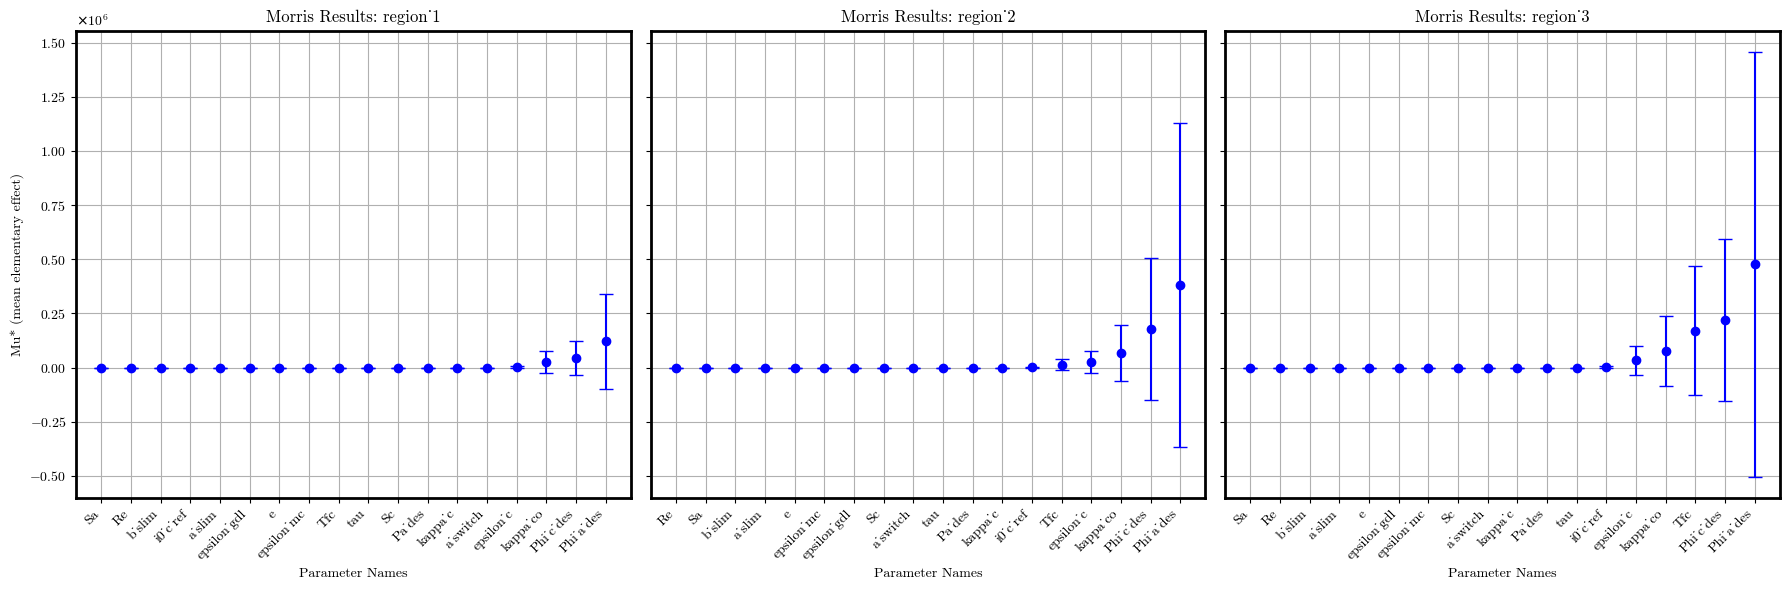

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_results_all_regions(morris_results):
    """
    Plots the Morris sensitivity analysis results for all regions.

    Parameters:
        morris_results (dict): Dictionary where keys are region names ('region_1', etc.)
                               and values are Morris analysis dictionaries.
    """
    regions = list(morris_results.keys())
    num_regions = len(regions)
    
    fig, axes = plt.subplots(1, num_regions, figsize=(6 * num_regions, 6), sharey=True)

    if num_regions == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, region in zip(axes, regions):
        result = morris_results[region]
        
        names = result['names']
        mu = result['mu_star']
        sigma = result['mu_star_conf']

        # Sort parameters
        sorted_indices = np.argsort(mu)
        names_sorted = np.array(names)[sorted_indices]
        mu_sorted = np.array(mu)[sorted_indices]
        sigma_sorted = np.array(sigma)[sorted_indices]

        # Plot
        ax.errorbar(names_sorted, mu_sorted, yerr=sigma_sorted, fmt='o', color='b', label='Mean ± Conf', capsize=5)
        ax.set_title(f'Morris Results: {region}')
        ax.set_xlabel('Parameter Names')
        ax.grid(True)

        # Rotate x-ticks
        ax.set_xticks(np.arange(len(names_sorted)))
        ax.set_xticklabels(names_sorted, rotation=45, ha='right')

    axes[0].set_ylabel('Mu* (mean elementary effect)')

    plt.tight_layout()
    plt.show()

# Example usage:
# morris_results = {'region_1': ..., 'region_2': ..., 'region_3': ...}
plot_morris_results_all_regions(morris_results)


### Morris analysiss using FPCA

Output function is decomposed into functional components using fPCA. Morris analysis is performed on a weighted average of the fPCA scores. 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA


Ucell_matrix = np.stack(data['Ucell'].apply(np.array)) 

# Perform FPCA via regular PCA
n_components = 5  # or choose based on explained variance
pca = PCA(n_components=n_components)
scores = pca.fit_transform(Ucell_matrix)


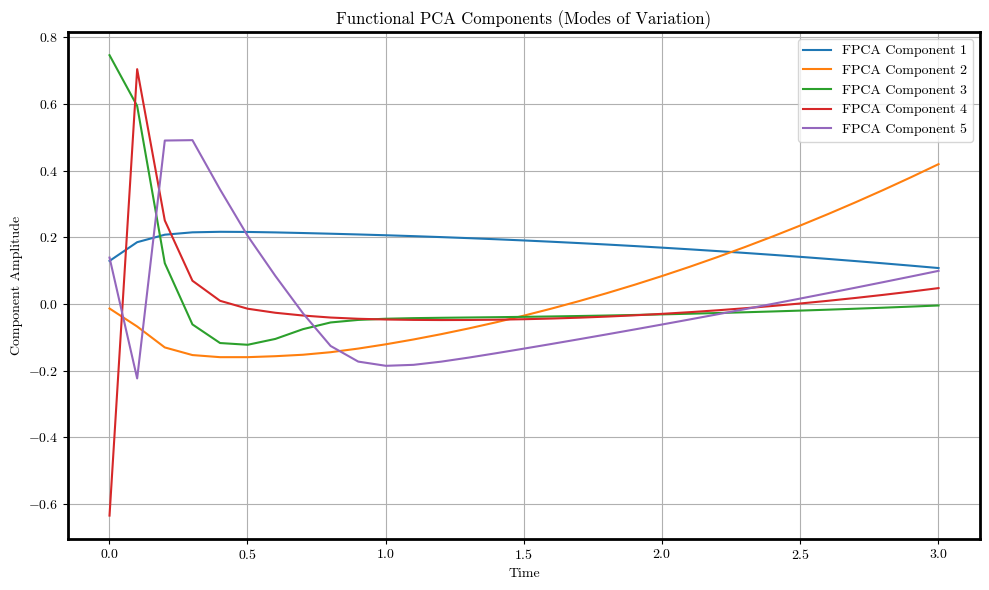

In [34]:
# Get the time grid (assuming it's the same for all samples)
time_grid = np.array(data['ifc'].iloc[0])

# Number of components to show
n_components_to_plot = 5

plt.figure(figsize=(10, 6))

for i in range(n_components_to_plot):
    plt.plot(time_grid, pca.components_[i], label=f"FPCA Component {i+1}")

plt.xlabel("Time")
plt.ylabel("Component Amplitude")
plt.title("Functional PCA Components (Modes of Variation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


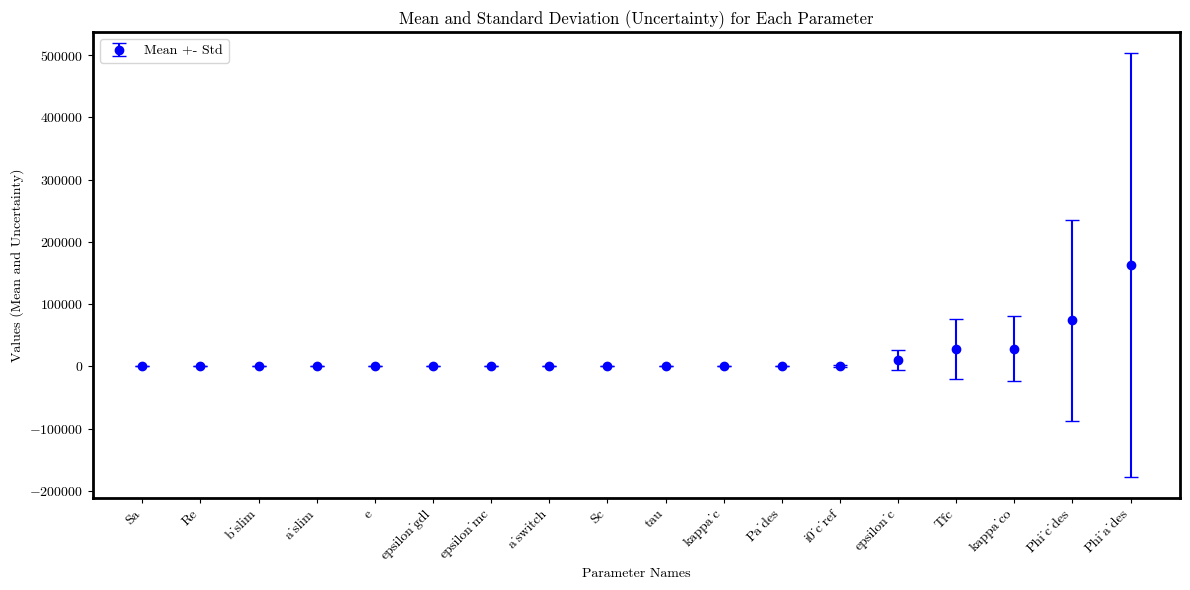

In [42]:
weights = pca.explained_variance_ratio_[:5]  # shape: (k,)
scalar_outputs = (scores[:, :5] * weights).sum(axis=1)


morris_all = morris_analyze.analyze(
            problem=problem,
            X=samples_df.to_numpy(),
            Y=scalar_outputs,
            conf_level=0.95,
            num_levels=4,
            print_to_console=False
        )

plot_morris_results(morris_all)